<a href="https://colab.research.google.com/github/ahmed27kar/PutableBond_Valuation_Model/blob/main/Putable_Data_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

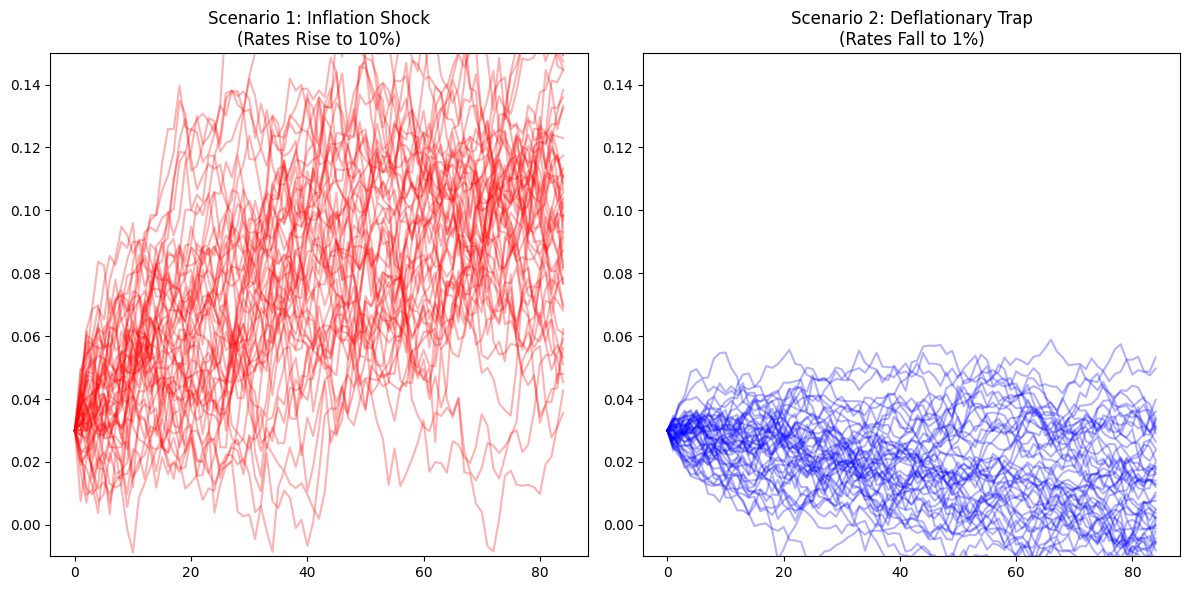

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. CONFIGURATION ---
num_paths = 1000
time_years = 7         # 7-Year Bond
steps_per_year = 12
dt = 1/steps_per_year
T = int(time_years * steps_per_year)

# --- 2. VASICEK FUNCTION (Standard) ---
def generate_paths(r0, kappa, theta, sigma, num_paths, T, dt):
    rates = np.zeros((T + 1, num_paths))
    rates[0] = r0
    for t in range(1, T + 1):
        Z = np.random.normal(0, 1, num_paths)
        r_prev = rates[t-1]
        dr = kappa * (theta - r_prev) * dt + sigma * np.sqrt(dt) * Z
        rates[t] = r_prev + dr
    return rates

# --- 3. DEFINE SCENARIOS (FLIPPED LOGIC) ---

# Scenario 1: "Inflation Shock" (Rates Rise -> Put is Valuable)
# Rates start low (3%) but drift up to 10%
rates_inflation = generate_paths(
    r0=0.03, kappa=0.4, theta=0.10, sigma=0.03,
    num_paths=num_paths, T=T, dt=dt
)

# Scenario 2: "Deflationary Trap" (Rates Fall -> Put is Worthless)
# Rates start at 3% and drift down to 1%
rates_deflation = generate_paths(
    r0=0.03, kappa=0.2, theta=0.01, sigma=0.01,
    num_paths=num_paths, T=T, dt=dt
)

# --- 4. VISUALIZATION ---
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(rates_inflation[:, :50], alpha=0.3, color='red')
plt.title('Scenario 1: Inflation Shock\n(Rates Rise to 10%)')
plt.ylim(-0.01, 0.15)

plt.subplot(1, 2, 2)
plt.plot(rates_deflation[:, :50], alpha=0.3, color='blue')
plt.title('Scenario 2: Deflationary Trap\n(Rates Fall to 1%)')
plt.ylim(-0.01, 0.15)

plt.tight_layout()
plt.show()

# --- 5. SAVE CSVs ---
pd.DataFrame(rates_inflation).to_csv('scenario_1_inflation.csv', index=False)
pd.DataFrame(rates_deflation).to_csv('scenario_2_deflation.csv', index=False)

In [2]:
# --- 1. PRICING CONFIGURATION ---
FACE_VALUE = 1000
COUPON_RATE = 0.03      # 3% Coupon
COUPON = FACE_VALUE * COUPON_RATE
YEARS = 7               # 7 Years
PUT_PRICE = 1000
PUTABLE_AFTER_YEAR = 3  # Investor can sell back after Year 3

put_start_step = PUTABLE_AFTER_YEAR * steps_per_year
total_steps = YEARS * steps_per_year

# --- 2. PUTABLE PRICING ENGINE ---
def price_putable_bond(rate_paths):
    bond_values = np.zeros_like(rate_paths)
    bond_values[-1, :] = FACE_VALUE

    for t in range(total_steps - 1, -1, -1):
        r_t = rate_paths[t, :]
        df = np.exp(-r_t * dt)

        cash_flow = bond_values[t+1, :]
        if (t + 1) % steps_per_year == 0:
            cash_flow += COUPON

        value_hold = cash_flow * df

        # --- THE CRITICAL CHANGE IS HERE ---
        if t >= put_start_step:
            # If Hold Value < 1000, Investor SELLS at 1000.
            # We take the MAXIMUM of (Hold Value, 1000)
            bond_values[t, :] = np.maximum(value_hold, PUT_PRICE)
        else:
            bond_values[t, :] = value_hold

    return np.mean(bond_values[0, :])

# --- 3. RUN MODEL ---
price_inflation = price_putable_bond(rates_inflation)
price_deflation = price_putable_bond(rates_deflation)

print(f"--- FINAL RESULTS (Putable Bond) ---")
print(f"Scenario 1 (Rates Rise 10%): ${price_inflation:.2f}")
print(f"Scenario 2 (Rates Fall 1%):  ${price_deflation:.2f}")

print("\n--- ANALYSIS ---")
if price_inflation > 950:
    print("Scenario 1 Proof: Rates skyrocketed, which usually destroys bond value.")
    print("However, the price stayed high because investors used the PUT Option.")

--- FINAL RESULTS (Putable Bond) ---
Scenario 1 (Rates Rise 10%): $921.62
Scenario 2 (Rates Fall 1%):  $1064.16

--- ANALYSIS ---
